# 01. PSPNet Pascal VOC

In [112]:
import os
import random
import torch
import cv2
import torchvision
import matplotlib.pyplot as plt

## 1. Loading the Pascal VOC dataset

### 1.1 Setup transforms

In [473]:
import torchvision.transforms as transforms

data_transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

### 1.2 Loading datasets

In [474]:
from torchvision import datasets

train_data = datasets.VOCSegmentation(root="./data",
                            year="2012",
                            image_set="train",
                            download="true",
                            transform=data_transform,
                            target_transform=data_transform)

test_data = datasets.VOCSegmentation(root="./data",
                                year="2012",
                                image_set="val",
                                download="true",
                                transform=data_transform,
                                target_transform=data_transform)

viz_data = datasets.VOCSegmentation(root="./data", year="2012", image_set="train")

Using downloaded and verified file: ./data\VOCtrainval_11-May-2012.tar
Extracting ./data\VOCtrainval_11-May-2012.tar to ./data
Using downloaded and verified file: ./data\VOCtrainval_11-May-2012.tar
Extracting ./data\VOCtrainval_11-May-2012.tar to ./data


### 1.3 Visualizing the data

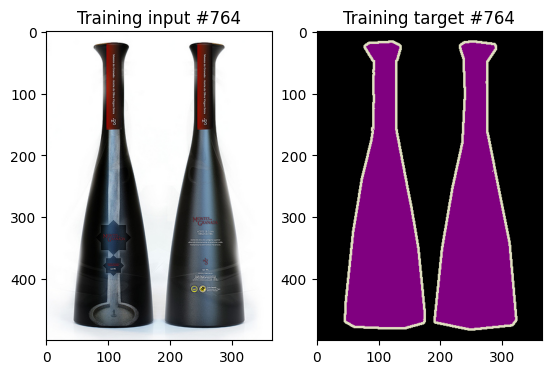

In [521]:
random_index = random.randint(0, len(viz_data))
(image, target) = viz_data[random_index]
plt.subplot(1, 2, 1)
plt.title("Training input #{id}".format(id = random_index))
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.title("Training target #{id}".format(id = random_index))
plt.imshow(target)

# 2. Prepare DataLoader

In [522]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)

print(f"train_dataloader: {len(train_dataloader)} * {BATCH_SIZE} images")
print(f"test_dataloader: {len(test_dataloader)} * {BATCH_SIZE} images")

train_dataloader: 46 * 32 images
test_dataloader: 46 * 32 images


In [525]:
train_dataloader